# Introduction

In this notebook, we want to study the two datasets in `beerAdv_beer_brewery.tsv` and in `rateBeer_beer_brewery.tsv`. The columns of these datasets are like this:

              beer_id ¦ beer_name ¦ brewery_id ¦ brewery_name
            
The idea of this notebook is to create a similarity measure in order to find the same elements in both these datasets. Once we have this similarity measure, we want to find the limit X such that:
- All pairs with a similarity value of $X' > X$ are considered as the same beer
- All pairs with a similarity value of $X'' < X$ are not taken into account.

In order to achieve this, this notebook is composed of three parts. The first part is some sort of simple Data Analysis. Then there will be the creation of the pairs and the similarity value. Finally the part to find the best value $X$.

In [1]:
# Usefule imports
import pandas as pd
import numpy as np
import codecs
from IPython.display import HTML
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
import multiprocessing
from joblib import Parallel, delayed
import pickle

# For the Pyth§on notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Data Analysis

First, we need to analyze the data. It's a simple data analysis since we only have two usefull features: `beer_name` and `brewery_name`.

In [59]:
# Datasets
beerAdvocate_dataset = './data/beerAdv_beer_brewery.tsv'
rateBeer_dataset = './data/rateBeer_beer_brewery.tsv'

In [60]:
columns = ['beer_id', 'beer_name', 'brewery_id', 'brewery_name']

In [254]:
# Load the dataset with pandas
beerAdvocate = pd.read_table(beerAdvocate_dataset, header=None)
beerAdvocate.columns = columns
rateBeer = pd.read_table(rateBeer_dataset, header=None, encoding='utf-8')
rateBeer.columns = columns

In [298]:
rateBeer.ix[9997]

beer_id                                   720
beer_name             Gambrinus Premium ?erné
brewery_id                                115
brewery_name    Plzensky Prazdroj (SABMiller)
Name: 9997, dtype: object

Print the two datasets

In [256]:
beerAdvocate.head()

,beer_id,beer_name,brewery_id,brewery_name
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [257]:
rateBeer.head()

,beer_id,beer_name,brewery_id,brewery_name
0,4,Abita Bock,1,Abita Brewing Company
1,10731,Abita Louisiana Red Ale,1,Abita Brewing Company
2,114065,Abita Select Pecan Brown Ale,1,Abita Brewing Company
3,114981,Abita Select Amber Ale,1,Abita Brewing Company
4,117017,Abita American Wheat,1,Abita Brewing Company


We just stop two minutes here. We can see a problem with the encoding of the file for *beerAdvocate*. 

In [258]:
name = beerAdvocate.ix[12].beer_name
print(name)

Master PolotmavÃ½ 13Â°


The encoding here is **latin_1**. Therefore, we can find the UTF-8 encoding by doing this:

In [259]:
new_name = bytes(name,'latin_1').decode('utf-8')
print(new_name)

Master Polotmavý 13°


Let's do it everywhere for *beerAdvocate*!

In [260]:
def decode_from_latin_1(string):
    try:
        return bytes(string ,'latin_1').decode('utf-8')
    except:
        return string

In [261]:
for i in range(len(beerAdvocate)):
    # Change the name of the beer
    beerAdvocate.set_value(i, 'beer_name', decode_from_latin_1(beerAdvocate.ix[i].beer_name))
    beerAdvocate.set_value(i, 'brewery_name', decode_from_latin_1(beerAdvocate.ix[i].brewery_name))


In [262]:
beerAdvocate.ix[12].beer_name

'Master Polotmavý 13°'

Let's print the number of entries in each dataset.

In [263]:
print("Number of rows in beerAdvocate: %i"%(len(beerAdvocate)))
print("Number of rows in rateBeer: %i"%(len(rateBeer)))

Number of rows in beerAdvocate: 66056
Number of rows in rateBeer: 110359


Let's check the number of **unique** beers to see if it matches the number of rows in the dataset.

In [264]:
unique_beers_beerAdvocate = beerAdvocate.beer_name.unique()
unique_beers_rateBeer = rateBeer.beer_name.unique()

print("Number of unique beers in beerAdvocate: %i"%(len(unique_beers_beerAdvocate)))
print("Number of unique beers in rateBeer: %i"%(len(unique_beers_rateBeer)))

Number of unique beers in beerAdvocate: 56855
Number of unique beers in rateBeer: 110302


It's already interesting to see that some beers have the same name in both datasets. Let's take one of them and see if they have the same `brewery_name`.

In [265]:
duplicated_beers_beerAdvocate = beerAdvocate[beerAdvocate.beer_name.duplicated()].beer_name.unique()
duplicated_beers_rateBeer = rateBeer[rateBeer.beer_name.duplicated()].beer_name.unique()

print("Number of duplicated beer names in beerAdvocate: %i"%(len(duplicated_beers_beerAdvocate)))
print("Number of duplicated beer names in rateBeer: %i"%(len(duplicated_beers_rateBeer)))

Number of duplicated beer names in beerAdvocate: 2707
Number of duplicated beer names in rateBeer: 55


In [266]:
dup_beer_dup_brewery = []

# Create list of tuples. 
#   First entry is the name of the duplicated beer
#   Second entry is the list of Brewery that is duplicated
#   Third entry is the list of indices to remove them easily.
for dup_beer in duplicated_beers_beerAdvocate:
    subdf = beerAdvocate[beerAdvocate.beer_name == dup_beer]
    if any(subdf.brewery_name.duplicated()):
        dup_beer_dup_brewery.append((dup_beer, list(subdf[subdf.brewery_name.duplicated()]["brewery_name"]), list(subdf[subdf.brewery_name.duplicated()].index)))

In [267]:
print("Number of beers with duplicated brewery in beerAdvocate: %i"%(len(dup_beer_dup_brewery)))

Number of beers with duplicated brewery in beerAdvocate: 286


Just check how the function `duplicated` works. For example, if we have two times the same brewery, this means that we would have 3 times the same beer and the same brewery in the data set.

In [268]:
dup_beer_dup_brewery[3]

('Saison',
 ['Triumph Brewing Company', 'Triumph Brewing Company'],
 [22563, 43875])

In [269]:
beerAdvocate[(beerAdvocate.beer_name == "Saison") & (beerAdvocate.brewery_name == "Triumph Brewing Company")]

,beer_id,beer_name,brewery_id,brewery_name
17881,49387,Saison,1317,Triumph Brewing Company
22563,37383,Saison,15341,Triumph Brewing Company
43875,24385,Saison,4832,Triumph Brewing Company


At this point, we imagine that the three entries are the same. But we directly see that the brewery_id is different. And if we go check the breweries on beerAdvocate, we see that the three Breweries are different. Therefore, we cannot say that these three beers are the same. In order to get a better similarity measure, we need to add a bit mopre information about the breweries and the beers. Here are the features we scrap from the websites:
- For the brewery:
    - The address
- For the beer:
    - The ABV (Alcohol by Volume)
    - The Style

At this point, we will not scrap the websites nor use other data. This will be done later in the project. Therefore, we just remove the duplicate indices.

In [273]:
indices_to_remove = []
for i in range(len(dup_beer_dup_brewery)):
    indices_to_remove.extend(dup_beer_dup_brewery[i][2])

In [274]:
# Remove the indices in the dataset
beerAdvocate = beerAdvocate.drop(indices_to_remove, axis=0)
beerAdvocate.index = range(len(beerAdvocate))
beerAdvocate.tail()

,beer_id,beer_name,brewery_id,brewery_name
65668,76042,Foster's Gold,575,Foster's Group Limited
65669,917,Foster's Special Bitter,575,Foster's Group Limited
65670,918,Foster's Lager,575,Foster's Group Limited
65671,52642,Hefe Weissbier,5751,Bayerische Löwenbrauerei
65672,58058,Hefeweissbier Dunkel,5751,Bayerische Löwenbrauerei


Now, we need to the same for the rateBeer dataset.

In [275]:
dup_beer_dup_brewery = []

# Create list of tuples. 
#   First entry is the name of the duplicated beer
#   Second entry is the list of Brewery that is duplicated
#   Third entry is the list of indices to remove them easily.
for dup_beer in duplicated_beers_rateBeer:
    subdf = rateBeer[rateBeer.beer_name == dup_beer]
    if any(subdf.brewery_name.duplicated()):
        dup_beer_dup_brewery.append((dup_beer, list(subdf[subdf.brewery_name.duplicated()]["brewery_name"]), list(subdf[subdf.brewery_name.duplicated()].index)))

In [276]:
print("Number of beers with duplicated brewery in beerRate: %i"%(len(dup_beer_dup_brewery)))

Number of beers with duplicated brewery in beerRate: 4


In [277]:
dup_beer_dup_brewery

[('Traugott Simon Export', ['Udo Täubrich Betreuungs'], [9819]),
 ('Big Horn Saison',
  ['Big Horn Brewing Company (Ram International)'],
  [19577]),
 ('Yukon Lead Dog Ale', ['Yukon Brewing Company'], [37365]),
 ('Prison Brews Winter Ale', ['Prison Brews'], [77632])]

In [278]:
indices_to_remove = []
for i in range(len(dup_beer_dup_brewery)):
    indices_to_remove.extend(dup_beer_dup_brewery[i][2])

In [279]:
# Remove the indices in the dataset
rateBeer = rateBeer.drop(indices_to_remove, axis=0)
rateBeer.index = range(len(rateBeer))
rateBeer.tail()

,beer_id,beer_name,brewery_id,brewery_name
110350,77397,Jelling Bryghus Frode Fredegod,8804,Jelling Bryghus
110351,77398,Jelling Bryghus Poppo,8804,Jelling Bryghus
110352,77399,Jelling Bryghus Jelling Jól,8804,Jelling Bryghus
110353,89887,Jelling Bryghus Jalunki,8804,Jelling Bryghus
110354,97191,Jelling Bryghus Sildeglimt,8804,Jelling Bryghus


### Save the cleaned data set

Now that the datasets are cleaned, we can save them in a CSV format.

In [280]:
beerAdvocate.to_csv('./data/beerAdvocate_cleaned.csv', index=False, encoding='utf-8')
rateBeer.to_csv('./data/rateBeer_cleaned.csv', index=False, encoding='utf-8')

# Similarity

** YOU CAN DIRECTLY START FROM HERE. NO NEED TO REDO THE CLEANING OF THE DATASETS! **

Now, we want to match beers between the two different datasets. Let's load them first. Then, we will create a matrix of size $N\times M$, $N$ being the size of *RateBeer* dataset and $M$ being the size of *BeerAdvocate* dataset. Since $M < N$, we want to get a vector of size $M\times 5$. (5 because we will aggregate the text columns and the id columns for each dataset and the similarity value.)

In [2]:
beerAdvocate = pd.read_csv('./data/beerAdvocate_cleaned.csv', dtype=str)
rateBeer = pd.read_csv('./data/rateBeer_cleaned.csv', dtype=str)

In [3]:
beerAdvocate.head()

,beer_id,beer_name,brewery_id,brewery_name
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [4]:
rateBeer.head()

,beer_id,beer_name,brewery_id,brewery_name
0,4,Abita Bock,1,Abita Brewing Company
1,10731,Abita Louisiana Red Ale,1,Abita Brewing Company
2,114065,Abita Select Pecan Brown Ale,1,Abita Brewing Company
3,114981,Abita Select Amber Ale,1,Abita Brewing Company
4,117017,Abita American Wheat,1,Abita Brewing Company


In [5]:
unique_rateBeer_breweries = rateBeer.brewery_name.unique()

We can now try to see the similarity between two strings.

In [68]:
def similarity_lines(line_1, line_2): 
    beer_val = fuzz.token_set_ratio(line_1.beer_name, line_2.beer_name)/100
    brewery_val = fuzz.token_set_ratio(line_1.brewery_name, line_2.brewery_name)/100
    return (beer_val*brewery_val)

def similarity(test):
    brewery = test.brewery_name.replace("'", "")
    beer = test.beer_name.replace("'", "")
    
    brewery_sim = np.zeros(len(unique_rateBeer_breweries))
    for i in range(len(unique_rateBeer_breweries)):
        brewery_sim[i] = fuzz.token_set_ratio(brewery, unique_rateBeer_breweries[i])/100.0
        
    idx_best_match_brewery = np.argmax(brewery_sim)
    best_match_brewery = np.max(brewery_sim)
    
    beer_names = list(rateBeer[rateBeer.brewery_name == unique_rateBeer_breweries[idx_best_match_brewery]].beer_name)
        
    N = len(beer_names)

    test_beers = np.zeros(N)
    for i in range(N):
        val1 = fuzz.token_set_ratio(beer, beer_names[i])/100.0
        if " " in beer:
            val2 = fuzz.partial_ratio(beer, beer_names[i])/100.0
        else:
            val2 = fuzz.ratio(beer, beer_names[i])/100.0
            if val2 < 1.0:
                val2 = val2/2.0

        test_beers[i] = val1*val2
        
    best_idx = np.argsort(test_beers)[::-1]
    
    nbr_match = 5
    if N < 5:
        nbr_match = N
    
    matches = []
    for i in range(nbr_match):
        matches.append((beer_names[best_idx[i]], 
                        unique_rateBeer_breweries[idx_best_match_brewery], 
                        test_beers[best_idx[i]]*best_match_brewery))
        
    ## Double check 
    # If the elements have the same best values, but the string is longer,
    # we have to put it first. (Problem with this algo)
    
    best_sim = matches[0][2]
    idx = [0]
    diff_length_beer_name = [abs(len(matches[0][0])-len(beer))]
    for i in range(1,nbr_match):
        if matches[i][2] == best_sim:
            idx.append(i)
            diff_length_beer_name.append(abs(len(matches[i][0])-len(beer)))
            
    best_idx = np.argsort(diff_length_beer_name)
    idx = np.asarray(idx)
    
    matches = np.asarray(matches)
    
    matches[idx] = matches[best_idx]
            
    return matches

In [67]:
bb=32
print(beerAdvocate.ix[bb])
print()
print(similarity(beerAdvocate.ix[bb]))

beer_id                               1814
beer_name       McNeill's Pullman's Porter
brewery_id                             100
brewery_name             McNeill's Brewery
Name: 32, dtype: object

[['McNeills Pullmans Porter' 'McNeills Brewery' '1.0']
 ['McNeills Troll' 'McNeills Brewery' '0.5767']
 ['McNeills Dubbel' 'McNeills Brewery' '0.511']
 ['McNeills Pilsner' 'McNeills Brewery' '0.5025']
 ['McNeills Kölsch' 'McNeills Brewery' '0.4891']]


In [69]:
nbr_jobs = multiprocessing.cpu_count()
nbr_jobs

8

** YOU CAN SKIP THIS PART AND SIMPLY UNZIP THE FILE `similarity.zip` IN DATA**

In [70]:
%%time
M = len(beerAdvocate)
N = len(rateBeer)

sim = Parallel(n_jobs=nbr_jobs)(delayed(similarity)(beerAdvocate.ix[idx]) for idx in range(M))

CPU times: user 48.1 s, sys: 1.69 s, total: 49.8 s
Wall time: 44min 16s


In [71]:
pickle.dump(sim, open('./data/similarity.pickle', "wb"))

** CONTINUE HERE **

In [6]:
sim = pickle.load(open('./data/similarity.pickle', "rb"))

In [7]:
sim[0]

array([['Eisbrau Czech', 'Plzensky Prazdroj (SABMiller)', '0.89'],
       ['Gambrinus Premium ?erné', 'Plzensky Prazdroj (SABMiller)',
        '0.11837'],
       ['Pilsner Urquell Kvasnicový', 'Plzensky Prazdroj (SABMiller)',
        '0.108224'],
       ['Gambrinus Svetlý 10° (Desítka)', 'Plzensky Prazdroj (SABMiller)',
        '0.108224'],
       ['Eger Urbier', 'Plzensky Prazdroj (SABMiller)', '0.105732']], 
      dtype='<U30')

In [8]:
best_sim = np.zeros(len(sim))
best_match_beer = []
best_match_brewery = []

In [9]:
for i in range(len(sim)):
    best_sim[i] = sim[i][0][2]
    best_match_beer.append(sim[i][0][0])
    best_match_brewery.append(sim[i][0][1])

In [10]:
matching_beers = beerAdvocate.copy()

In [11]:
matching_beers.columns = [s + '_beerAdvocate' for s in matching_beers.columns]

In [12]:
matching_beers.head()

,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [13]:
matching_beers['beer_name_rateBeer'] = best_match_beer
matching_beers['brewery_name_rateBeer'] = best_match_brewery
matching_beers['similarity'] = best_sim

In [14]:
matching_beers.head()


,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s.",Eisbrau Czech,Plzensky Prazdroj (SABMiller),0.890000
1,19099,Primus,1,"Plzensky Prazdroj, a. s.",Primus Sv&#283tlé (Pale),Plzensky Prazdroj (SABMiller),0.178000
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s.",Gambrinus Bílé,Plzensky Prazdroj (SABMiller),0.604666
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell,Plzensky Prazdroj (SABMiller),0.046992
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell 3.5%,Plzensky Prazdroj (SABMiller),0.890000


In [16]:
matching_beers[matching_beers.beer_name_rateBeer.duplicated(keep=False)]

,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell,Plzensky Prazdroj (SABMiller),0.046992
5,429,Pilsner Urquell,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell,Plzensky Prazdroj (SABMiller),0.890000
10,59315,Master Zlatý 15°,1,"Plzensky Prazdroj, a. s.",Gambrinus Master,Plzensky Prazdroj (SABMiller),0.202920
11,67962,Master Tmavý 18°,1,"Plzensky Prazdroj, a. s.",Gambrinus Master,Plzensky Prazdroj (SABMiller),0.202920
12,69068,Master Polotmavý 13°,1,"Plzensky Prazdroj, a. s.",Gambrinus Master,Plzensky Prazdroj (SABMiller),0.186010
21,12912,McNeill's Doc Feelgood's Pils,100,McNeill's Brewery,McNeills Troll,McNeills Brewery,0.518300
26,12918,McNeill's Tartan Export,100,McNeill's Brewery,McNeills Tartan Export Ale,McNeills Brewery,1.000000
35,2187,McNeill's Old Ringworm,100,McNeill's Brewery,McNeills Old Ringworm,McNeills Brewery,1.000000
41,33212,McNeill's Imperial IPA,100,McNeill's Brewery,McNeills Imperial Stout,McNeills Brewery,0.765400
42,42457,McNeill's Summer Brown Ale,100,McNeill's Brewery,McNeills Summer Brown Ale,McNeills Brewery,1.000000


In [17]:
matching_beers.sort_values(by='similarity', ascending=False, inplace=True)

In [18]:
matching_beers.similarity.describe()

count    65673.000000
mean         0.537842
std          0.371836
min          0.000000
25%          0.172200
50%          0.474500
75%          1.000000
max          1.000000
Name: similarity, dtype: float64

<function matplotlib.pyplot.show>

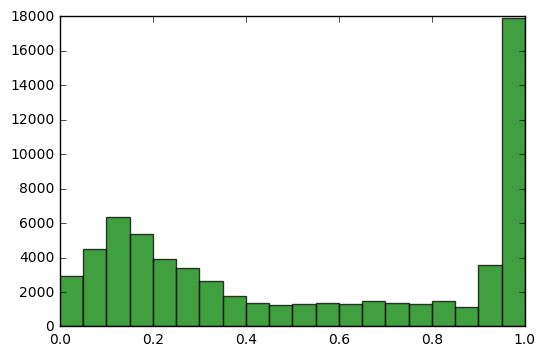

In [19]:
plt.hist(list(matching_beers.similarity), 20, facecolor='green', alpha=0.75)
plt.show

In [53]:
threshold = 0.65 # Chosen empirically
good_matching_beers = matching_beers[matching_beers.similarity >= threshold]
good_matching_beers.index = range(len(good_matching_beers))
print("Number of good matching beers: %i"%len(good_matching_beers))
print("Percentage of good matching beers: %.2f"%(len(good_matching_beers)/len(matching_beers)*100.0))

Number of good matching beers: 28208
Percentage of good matching beers: 42.95


In [54]:
good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()]

,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
63,38583,Ashbury Alt,463,Magnolia Pub & Brewery,Magnolia Ashbury Alt,Magnolia Pub and Brewery,1.000000
183,2614,La Moneuse Spéciale Noël,825,Brasserie de Blaugies,La Moneuse,Brasserie de Blaugies,1.000000
284,8727,Unertl Weissbier,3694,Unertl Weissbier GmbH,Unertl Weissbier Bock,Unertl Weissbier,1.000000
291,76704,Fässla Weizla Hell,471,Brauerei Fässla,Fässla Weizla Hell,Brauerei Fässla,1.000000
306,1813,Petite Orval,37,Brasserie d'Orval S.A.,Orval,Brasserie dOrval,1.000000
439,57902,Maccabee Lager Beer,204,Tempo Beer Industries LTD,Maccabee,Tempo Beer,1.000000
482,12428,Straubinger Weisse,5138,Brauerei Gebrüder Röhrl,Straubinger Weisse Dunkel,Brauerei Gebrüder Röhrl,1.000000
510,5961,Boon Oude Kriek Mariage Parfait,47,Brouwerij Boon,Boon Oude Kriek,Brouwerij F. Boon,1.000000
536,38202,Boon Oude Geuze Mariage Parfait Single Cask #52,47,Brouwerij Boon,Boon Oude Geuze Mariage Parfait,Brouwerij F. Boon,1.000000
538,44591,Boon Oude Geuze Mariage Parfait Single Cask #59,47,Brouwerij Boon,Boon Oude Geuze Mariage Parfait,Brouwerij F. Boon,1.000000


In [55]:
duplicated_beer_names = good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()].beer_name_rateBeer.unique()

In [56]:
index_to_remove = []
for bn in duplicated_beer_names:
    df = good_matching_beers[good_matching_beers.beer_name_rateBeer == bn]
    ratio = []
    for i in df.index:
        val1 = fuzz.ratio(df.ix[i]['beer_name_beerAdvocate'], df.ix[i]['beer_name_rateBeer'])/100
        val2 = fuzz.ratio(df.ix[i]['brewery_name_beerAdvocate'], df.ix[i]['brewery_name_rateBeer'])/100
        ratio.append(val1*val2)
    df['ratio'] = ratio
    max_ratio = np.max(ratio)
    beer_test = df.ix[df.index[0]].beer_name_rateBeer
    if " " in beer_test:
        index_to_remove.extend(list(df[df.ratio != max_ratio].index))
    else:
        if max_ratio < 0.9:
            index_to_remove.extend(list(df.index))
        else:
            index_to_remove.extend(list(df[df.ratio != max_ratio].index))

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
index_to_remove[0]

63

In [58]:
good_matching_beers = good_matching_beers.drop(index_to_remove)
good_matching_beers.index = range(len(good_matching_beers))

In [59]:
good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()]

,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
6291,20146,Portsmouth Hop Harvest #1,596,Portsmouth Brewery,Portsmouth Hop Harvest,Portsmouth Brewery,1.000000
6572,36580,"Harboe Pilsner 2,8%",1463,Harboes Bryggeri A/S,Harboe Pilsner,Harboes Bryggeri,1.000000
7113,22056,Jasper Murdock's Private Stock '04,343,Jasper Murdock's Alehouse,Jasper Murdocks Private Stock,Jasper Murdocks Alehouse,1.000000
7164,64976,Jasper Murdock's Private Stock '09,343,Jasper Murdock's Alehouse,Jasper Murdocks Private Stock,Jasper Murdocks Alehouse,1.000000
7171,2627,Jasper Murdock's Private Stock '03,343,Jasper Murdock's Alehouse,Jasper Murdocks Private Stock,Jasper Murdocks Alehouse,1.000000
7879,46140,Brass Ass,11212,Iron Horse Brewery,Iron Horse Brass Ass Brown Ale,Iron Horse Brewery,1.000000
8061,64483,Bell's Eccentric Ale 2009 (Released 2010),287,"Bell's Brewery, Inc.",Bells Eccentric Ale,Bells Brewery,1.000000
8080,76246,Bell's Eccentric Ale 2010 (Released 2011),287,"Bell's Brewery, Inc.",Bells Eccentric Ale,Bells Brewery,1.000000
8094,34267,Bell's Eccentric Ale 2005 (Released 2006),287,"Bell's Brewery, Inc.",Bells Eccentric Ale,Bells Brewery,1.000000
8101,28832,Bell's Eccentric Ale 2004 (Released 2005),287,"Bell's Brewery, Inc.",Bells Eccentric Ale,Bells Brewery,1.000000


In [61]:
duplicated_beer_names = good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()].beer_name_rateBeer.unique()

In [63]:
index_to_remove = []
for bn in duplicated_beer_names:
    df = good_matching_beers[good_matching_beers.beer_name_rateBeer == bn]
    ratio = []
    for i in df.index:
        val1 = fuzz.ratio(df.ix[i]['beer_name_beerAdvocate'], df.ix[i]['beer_name_rateBeer'])/100
        val2 = fuzz.ratio(df.ix[i]['beer_name_rateBeer'], df.ix[i]['beer_name_beerAdvocate'])/100
        ratio.append(val1*val2)
    df['ratio'] = ratio 
    index_to_remove.extend(list(df.index))
    print(df)

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


     beer_id_beerAdvocate     beer_name_beerAdvocate brewery_id_beerAdvocate  \
6109                45136  Portsmouth Hop Harvest #2                     596   
6291                20146  Portsmouth Hop Harvest #1                     596   

     brewery_name_beerAdvocate      beer_name_rateBeer brewery_name_rateBeer  \
6109        Portsmouth Brewery  Portsmouth Hop Harvest    Portsmouth Brewery   
6291        Portsmouth Brewery  Portsmouth Hop Harvest    Portsmouth Brewery   

      similarity   ratio  
6109         1.0  0.8836  
6291         1.0  0.8836  
     beer_id_beerAdvocate beer_name_beerAdvocate brewery_id_beerAdvocate  \
6538                36720    Harboe Pilsner 3,5%                    1463   
6572                36580    Harboe Pilsner 2,8%                    1463   

     brewery_name_beerAdvocate beer_name_rateBeer brewery_name_rateBeer  \
6538      Harboes Bryggeri A/S    Harboe Pilsner       Harboes Bryggeri   
6572      Harboes Bryggeri A/S    Harboe Pilsner       Har

We can cleary see the problems with the remaining duplicates. It's impossible to distinguish between without further information. Therefore, we decide to just remove all the indexes.

In [64]:
good_matching_beers = good_matching_beers.drop(index_to_remove)
good_matching_beers.index = range(len(good_matching_beers))

In [66]:
print("Final length of matching beers: %i"%len(good_matching_beers))

Final length of matching beers: 26544


In [80]:
beer_id_rateBeer = rateBeer.set_index('beer_name').to_dict()['beer_id']
brewery_id_rateBeer = rateBeer.set_index('brewery_name').to_dict()['brewery_id']

In [87]:
beer_id_rateBeer_list = []
brewery_id_rateBeer_list = []
for i in range(len(good_matching_beers)):
    beer_id_rateBeer_list.append(beer_id_rateBeer[good_matching_beers.ix[i].beer_name_rateBeer])
    brewery_id_rateBeer_list.append(brewery_id_rateBeer[good_matching_beers.ix[i].brewery_name_rateBeer])
good_matching_beers['beer_id_rateBeer'] = beer_id_rateBeer_list
good_matching_beers['brewery_id_rateBeer'] = brewery_id_rateBeer_list

In [89]:
# Rearrange columns
good_matching_beers = good_matching_beers[['beer_id_beerAdvocate', 'beer_name_beerAdvocate', 'brewery_id_beerAdvocate', 'brewery_name_beerAdvocate', 'beer_id_rateBeer', 'beer_name_rateBeer', 'brewery_id_rateBeer', 'brewery_name_rateBeer', 'similarity']]

In [92]:
# Save the Cleaned CSV
good_matching_beers.to_csv('./data/matching_beers.csv', index=False)

